# Quantile Linear Regression

Quantile regression models the conditional quantiles of a target variable instead of just the mean (least square method), making it useful for capturing uncertainty in predictions.  

**Key Ideas**  
- Focuses on ranking observations correctly rather than minimizing error.
- Uses a quantile loss function to estimate specific quantiles of the target distribution.  
- Setting ( $\alpha = 0.5$ ) makes the model predict the conditional median of the response variable.  
- Enables the creation of prediction intervals by estimating lower and upper quantiles.  
- Provides a "trust region" where the true value is likely to fall, depending on chosen quantiles.  
- River package: specialize in online training for data stream.

**Model documentation**: https://riverml.xyz/latest/examples/quantile-regression-uncertainty/

**Requirements:**

!pip install river

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [1]:
# Standard library imports
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

try:
    from birdgame.trackers.trackerbase import TrackerBase
except:
    # Trick to be on root directory (to remove in the future and use install birdgame)
    # Change the working directory to the root of the package
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
    os.chdir(root_dir)
    
# Birdgame package imports
from birdgame.trackers.trackerbase import TrackerBase
from birdgame.visualization.viz_quantile_regression import visualize_quantile_regression

### Warm up example: Quantile regression

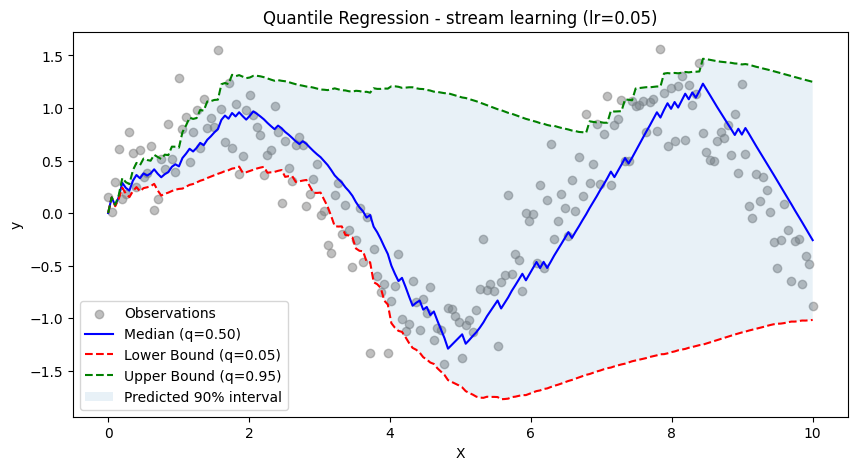

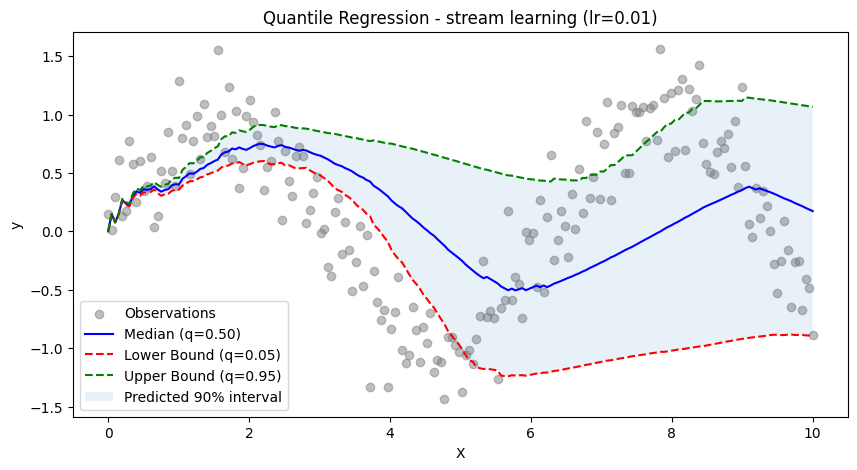

In [2]:
# Run quantile regression for different learning rates
for lr in [0.05, 0.01]:
    visualize_quantile_regression(lr=lr)

In [3]:
import numpy as np
from river import linear_model, optim
from river import preprocessing
    

class QuantileRegressionRiverTracker(TrackerBase):
    """
    A model that tracks the dove location using Quantile regression on stream learning.

    Parameters
    ----------
    horizon : int
        The number of time steps into the future that predictions should be made for.
    """

    def __init__(self):
        super().__init__(Constants.HORIZON)
        self.current_x = None
        self.miss_count = 0

        # Initialize river models dictionary
        self.models = {}
        self.lr = 0.005
        for i, alpha in enumerate([0.05, 0.5, 0.95]):
            scale = preprocessing.StandardScaler()

            # you can optimize learning rate or use other optimizer (RMSProp, ...)
            learn = linear_model.LinearRegression(
                intercept_lr=0,
                optimizer=optim.SGD(self.lr),
                loss=optim.losses.Quantile(alpha=alpha)
            )

            model = scale | learn

            self.models[f"q {alpha:.2f}"] = preprocessing.TargetStandardScaler(regressor=model)

    def tick(self, payload):
        """
        Ingest a new record (payload), store it internally and update the model.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        """

        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x
        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:

            ### (optional idea)
            # Get the predicted quantile values from the models
            if "q 0.05" in self.models:
                y_lower = self.models["q 0.05"].predict_one({"x": prev_x})
                y_upper = self.models["q 0.95"].predict_one({"x": prev_x})

                # Check if observed value `x` is between the predicted quantiles
                if y_lower <= x <= y_upper:
                    prediction_error = 0  # prediction is within bounds
                    # idea: learn two time when prediction is within bounds
                    for i, alpha in enumerate([0.05, 0.5, 0.95]):
                        self.models[f"q {alpha:.2f}"].learn_one({"x": prev_x}, x)
                else:
                    prediction_error = 1  # prediction is outside bounds
            ###

            # River learn_one (online learning)
            for i, alpha in enumerate([0.05, 0.5, 0.95]):
                self.models[f"q {alpha:.2f}"].learn_one({"x": prev_x}, x)

            self.count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution
        modeled as a Gaussian distribution.
        """
        x_mean = self.current_x
        components = []

        if "q 0.05" in self.models:
            # Quantile regression prediction 5%, 50% and 95%
            y_lower = self.models["q 0.05"].predict_one({"x": self.current_x})
            y_mean = self.models["q 0.50"].predict_one({"x": self.current_x})
            y_upper = self.models["q 0.95"].predict_one({"x": self.current_x})

            loc = x_mean #y_mean
            scale = np.abs((y_upper - y_lower)) / 3.289707253902945    # 3.289707253902945 = (norm.ppf(0.95) - norm.ppf(0.05))
            scale = max(scale, 1e-6)
        else:
            loc = x_mean
            scale = 1.0

        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }
        return prediction_density

### Tracker experimentation

The model is experimented on a data generator using the [density_pdf](https://github.com/microprediction/densitypdf/blob/main/densitypdf/__init__.py) scoring. For a gaussian distribution, it is:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [4]:
# Parameters
class Constants:
    HORIZON = 10

### Run on a remote static data file

In [5]:
# Initialize Tracker
tracker = QuantileRegressionRiverTracker()

# Run on remote data
tracker.test_run(live=False)

0it [00:00, ?it/s]

My median score: 21.3812 VS Benchmark median score: 45.1315
My median score: 18.5582 VS Benchmark median score: 40.4615
My median score: 19.0535 VS Benchmark median score: 36.1056
My median score: 23.0357 VS Benchmark median score: 36.2405
My median score: 24.7803 VS Benchmark median score: 35.8028
My median score: 26.3526 VS Benchmark median score: 35.8409
My median score: 25.6065 VS Benchmark median score: 34.9872
My median score: 22.4194 VS Benchmark median score: 34.0070
My median score: 22.3308 VS Benchmark median score: 32.9959
My median score: 20.7599 VS Benchmark median score: 32.0830
My median score: 21.7156 VS Benchmark median score: 31.6792
My median score: 21.7876 VS Benchmark median score: 31.1856
My median score: 21.1127 VS Benchmark median score: 30.5950
My median score: 22.0102 VS Benchmark median score: 30.5148
My median score: 22.1114 VS Benchmark median score: 30.5421
My median score: 21.9415 VS Benchmark median score: 30.2813
My median score: 22.7989 VS Benchmark me

### Run on live data

In [6]:
# Initialize Tracker
tracker = QuantileRegressionRiverTracker()

# Run on live data
tracker.test_run(live=True)
# Interrupt cell to stop run

0it [00:00, ?it/s]

My median score: 5.3813 VS Benchmark median score: 0.1782
Interrupted


### An animated run

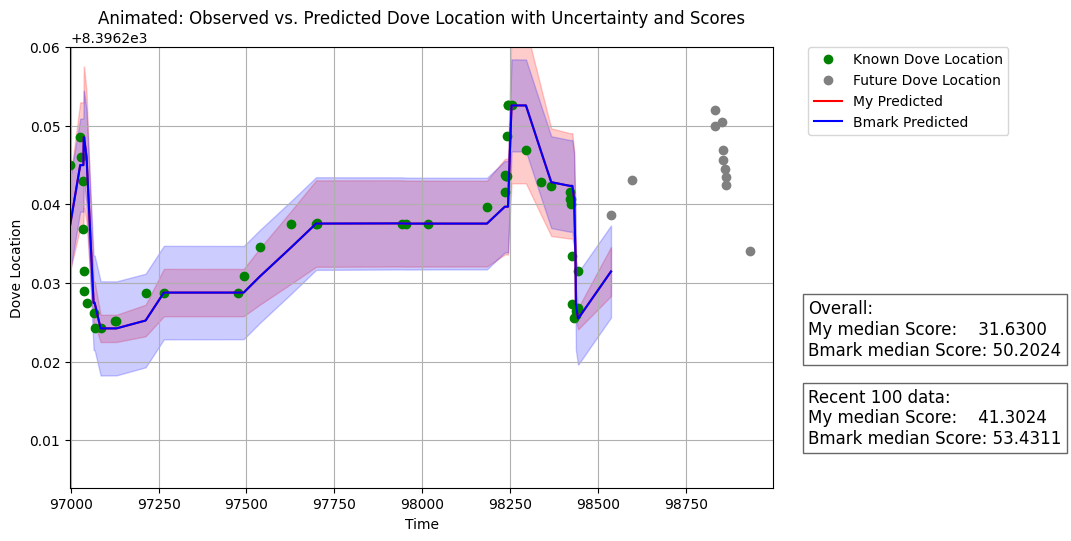

KeyboardInterrupt: 

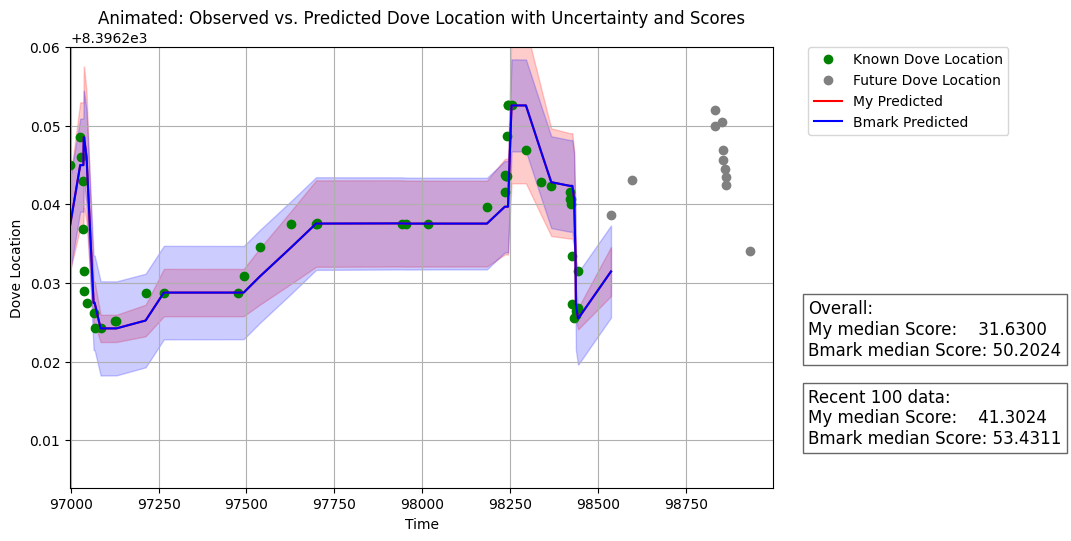

In [7]:
%matplotlib inline
from IPython.display import HTML

# Initialize Tracker
tracker = QuantileRegressionRiverTracker()

# Run on live data
animated = tracker.test_run_animated(live=False, recent_score_window_size=100, from_notebook=True)

# Display animation in notebook
HTML(animated.to_jshtml())